# Import Libraries

In [2]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns
# from IPython.display import display, Markdown
# import numpy as np
from sklearn.model_selection import train_test_split
# from sklearn.datasets import load_iris
# from sklearn.linear_model import LogisticRegression
# from sklearn import preprocessing
# from sklearn import utils
# from sklearn.svm import SVC
# from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LinearRegression
# from sklearn.svm import SVR
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# from sklearn import linear_model
# from sklearn.metrics import make_scorer
# from sklearn.model_selection import cross_validate
# from sklearn.preprocessing import PolynomialFeatures

# Import Datasets

In [3]:
games = pd.read_csv('data/games.csv')
details = pd.read_csv('data/games_details.csv')
teams = pd.read_csv('data/teams.csv')
players = pd.read_csv('data/players.csv')
ranking = pd.read_csv('data/ranking.csv')

C:\Users\tojoy\AppData\Local\Temp\ipykernel_39268\1677706802.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  details = pd.read_csv('data/games_details.csv')


# Data Preparation

## Get Labels
Here we drop the rows when a team didn't play enough games in one season (not 82 games).

In [4]:
def get_labels(ranking):
    temp = ranking.copy(deep=False)
    temp = temp.groupby(['TEAM_ID','SEASON_ID'])['G','W'].max()
    temp = pd.DataFrame(temp)
    temp.reset_index(inplace=True)
    drops = []
    for i in range(len(temp)):
        if temp.iloc[i,1] / 10000 > 2:
            temp.iloc[i,1] = temp.iloc[i,1] % 10000
        else:
            drops.append(i)
            continue;
        if (temp.iloc[i,2] != 82):
            drops.append(i)
    for i in range(len(drops)):
        temp.drop([drops[i]], inplace=True)
    temp.reset_index(inplace=True)
    temp.drop(columns=['index'], inplace=True)
    temp.drop(columns=['G'], inplace=True)
#     temp = pd.merge(temp, ranking, how='left', left_on=['TEAM_ID','STANDINGSDATE'], right_on = ['TEAM_ID','STANDINGSDATE'])
#     temp.drop(columns=['STANDINGSDATE','LEAGUE_ID','SEASON_ID_y','CONFERENCE','TEAM','G','W','L','HOME_RECORD','ROAD_RECORD','RETURNTOPLAY'], inplace=True)
    return temp

In [5]:
labels = get_labels(ranking)
labels

C:\Users\tojoy\AppData\Local\Temp\ipykernel_39268\989031293.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = temp.groupby(['TEAM_ID','SEASON_ID'])['G','W'].max()


,TEAM_ID,SEASON_ID,W
0,1610612737,2002,35
1,1610612737,2003,28
2,1610612737,2004,13
3,1610612737,2005,26
4,1610612737,2006,30
...,...,...,...
501,1610612766,2015,48
502,1610612766,2016,36
503,1610612766,2017,36
504,1610612766,2018,39


## Get Features

In [6]:
def get_features(games, details):
    temp = pd.merge(games, details, how='left', left_on=['GAME_ID'], right_on = ['GAME_ID'])
    temp = temp[['TEAM_ID','SEASON','FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA'
             ,'FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS']]
    temp = temp.groupby(['TEAM_ID','SEASON'])['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA'
             ,'FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS'].sum()
    temp = pd.DataFrame(temp)
    next_season = []
    temp.reset_index(inplace=True)
    for i in range(len(temp)):
        next_season.append(temp.iloc[i,1] + 1)
    temp['NEXT_SEASON'] = next_season
    return temp

In [7]:
features = get_features(games, details)
features

C:\Users\tojoy\AppData\Local\Temp\ipykernel_39268\2543770804.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = temp.groupby(['TEAM_ID','SEASON'])['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA'


,TEAM_ID,SEASON,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,NEXT_SEASON
0,1.610613e+09,2003,2857.0,6609.0,320.764,422.0,1256.0,104.083,1555.0,2004.0,...,2543.0,3548.0,1666.0,633.0,410.0,1292.0,1853.0,7691.0,-1905.0,2004
1,1.610613e+09,2004,2997.0,6821.0,357.705,309.0,997.0,114.160,1456.0,2059.0,...,2387.0,3510.0,1649.0,642.0,350.0,1289.0,2068.0,7759.0,-3983.0,2005
2,1.610613e+09,2005,3196.0,6997.0,358.522,450.0,1205.0,138.741,1804.0,2404.0,...,2427.0,3568.0,1759.0,633.0,417.0,1377.0,2235.0,8646.0,-1950.0,2006
3,1.610613e+09,2006,3105.0,6986.0,369.110,385.0,1161.0,127.166,1865.0,2438.0,...,2528.0,3595.0,1728.0,663.0,480.0,1400.0,2195.0,8460.0,-1950.0,2007
4,1.610613e+09,2007,3457.0,7668.0,382.692,436.0,1250.0,122.879,2129.0,2758.0,...,2885.0,4074.0,2084.0,696.0,536.0,1411.0,2016.0,9479.0,-1165.0,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,1.610613e+09,2018,3495.0,7788.0,413.804,1043.0,2949.0,245.989,1619.0,2046.0,...,2980.0,3824.0,2029.0,625.0,435.0,1038.0,1679.0,9652.0,-330.0,2019
595,1.610613e+09,2019,2615.0,6015.0,297.664,839.0,2397.0,180.742,1135.0,1506.0,...,2249.0,3012.0,1668.0,466.0,297.0,1008.0,1333.0,7204.0,-2260.0,2020
596,1.610613e+09,2020,3210.0,7117.0,352.732,1095.0,2976.0,211.146,1299.0,1729.0,...,2704.0,3559.0,2173.0,640.0,386.0,1160.0,1485.0,8814.0,-899.0,2021
597,1.610613e+09,2021,3685.0,7945.0,398.470,1190.0,3301.0,218.024,1373.0,1859.0,...,2934.0,3877.0,2409.0,747.0,428.0,1129.0,1736.0,9933.0,-380.0,2022


## Get Full Dataset
Here we drop NaN values. We then do inner join of the two tables, so some values are also dropped because some values don't exist in both tables.

In [8]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [9]:
def get_data(ranking, games, details):
    labels = get_labels(ranking)
    features = get_features(games, details)
    data = pd.merge(labels, features, how='left', left_on=['TEAM_ID','SEASON_ID'], right_on = ['TEAM_ID','NEXT_SEASON'])
    data.drop(columns=['SEASON_ID','SEASON'], inplace=True)
    data.dropna(inplace=True)
    data = swap_columns(data, 'W', 'NEXT_SEASON')
    data = data.astype({'NEXT_SEASON': 'int64'})
    data.rename(columns={'W' : 'NEXT_W'}, inplace=True)
    data.reset_index(inplace=True)
    data.drop(columns=['index'], inplace=True)
    return data

In [10]:
data = get_data(ranking, games, details)
data

C:\Users\tojoy\AppData\Local\Temp\ipykernel_39268\989031293.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = temp.groupby(['TEAM_ID','SEASON_ID'])['G','W'].max()
C:\Users\tojoy\AppData\Local\Temp\ipykernel_39268\2543770804.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = temp.groupby(['TEAM_ID','SEASON'])['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA'


,TEAM_ID,NEXT_SEASON,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,NEXT_W
0,1610612737,2004,2857.0,6609.0,320.764,422.0,1256.0,104.083,1555.0,2004.0,...,2543.0,3548.0,1666.0,633.0,410.0,1292.0,1853.0,7691.0,-1905.0,13
1,1610612737,2005,2997.0,6821.0,357.705,309.0,997.0,114.160,1456.0,2059.0,...,2387.0,3510.0,1649.0,642.0,350.0,1289.0,2068.0,7759.0,-3983.0,26
2,1610612737,2006,3196.0,6997.0,358.522,450.0,1205.0,138.741,1804.0,2404.0,...,2427.0,3568.0,1759.0,633.0,417.0,1377.0,2235.0,8646.0,-1950.0,30
3,1610612737,2007,3105.0,6986.0,369.110,385.0,1161.0,127.166,1865.0,2438.0,...,2528.0,3595.0,1728.0,663.0,480.0,1400.0,2195.0,8460.0,-1950.0,37
4,1610612737,2008,3457.0,7668.0,382.692,436.0,1250.0,122.879,2129.0,2758.0,...,2885.0,4074.0,2084.0,696.0,536.0,1411.0,2016.0,9479.0,-1165.0,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,1610612766,2015,3191.0,7612.0,370.551,551.0,1736.0,154.944,1547.0,2057.0,...,3070.0,3965.0,1833.0,552.0,492.0,1017.0,1691.0,8480.0,-1430.0,48
443,1610612766,2016,3528.0,8122.0,425.323,987.0,2745.0,266.812,1859.0,2352.0,...,3403.0,4246.0,2027.0,691.0,485.0,1140.0,1758.0,9902.0,1195.0,36
444,1610612766,2017,3318.0,7589.0,387.285,866.0,2526.0,188.367,1741.0,2146.0,...,3111.0,3904.0,2024.0,621.0,425.0,1004.0,1486.0,9243.0,-175.0,36
445,1610612766,2018,3386.0,7537.0,390.534,872.0,2379.0,212.096,1738.0,2334.0,...,3078.0,3954.0,1869.0,594.0,393.0,1093.0,1502.0,9382.0,90.0,39


In [11]:
data.to_csv('data/nba_data.csv')

## Feature Scaling
We use z-score normalization.

In [12]:
def scale_data(data):
    temp = data.copy(deep=False)
    std_slc = StandardScaler()
    preprocess = std_slc.fit_transform(temp[['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA'
             ,'FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS']])
#     preprocess = preprocessing.normalize(temp[['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA'
#              ,'FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS']])
    data_scaled = pd.DataFrame(preprocess, columns=['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM'
                    ,'FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS'])
    data_scaled.insert(0,'TEAM_ID',temp[['TEAM_ID']])
    data_scaled.insert(1,'NEXT_SEASON',temp[['NEXT_SEASON']])
    data_scaled.insert(21,'NEXT_W',temp[['NEXT_W']])
    return data_scaled

In [13]:
data_scaled = scale_data(data)
data_scaled

,TEAM_ID,NEXT_SEASON,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,NEXT_W
0,1610612737,2004,-1.411461,-1.264087,-1.498915,-1.106395,-1.073258,-1.705786,-0.471266,-0.614104,...,-0.976307,-0.816891,-1.158351,-0.629734,-0.391299,0.083757,-0.344346,-1.358318,-0.988451,13
1,1610612737,2005,-1.059369,-0.977735,-0.786667,-1.577773,-1.486932,-1.490412,-0.839727,-0.461249,...,-1.413032,-0.907023,-1.218349,-0.541993,-1.073390,0.063306,0.511068,-1.297323,-2.069663,26
2,1610612737,2006,-0.558896,-0.740009,-0.770914,-0.989593,-1.154715,-0.965047,0.455471,0.497565,...,-1.301051,-0.769454,-0.830124,-0.629734,-0.311722,0.663208,1.175506,-0.501689,-1.011865,30
3,1610612737,2007,-0.787756,-0.754867,-0.566770,-1.260740,-1.224992,-1.212437,0.682503,0.592057,...,-1.018299,-0.705412,-0.939533,-0.337266,0.404473,0.820000,1.016359,-0.668530,-1.011865,37
4,1610612737,2008,0.097503,0.166323,-0.304900,-1.047994,-1.082842,-1.304063,1.665067,1.481392,...,-0.018870,0.430724,0.316904,-0.015550,1.041091,0.894988,0.304177,0.245508,-0.603419,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,1610612766,2015,-0.571471,0.090682,-0.538987,-0.568274,-0.306604,-0.618743,-0.501040,-0.466808,...,0.499041,0.172188,-0.568954,-1.419399,0.540891,-1.790936,-0.988891,-0.650590,-0.741302,48
443,1610612766,2016,0.276064,0.779548,0.517056,1.250493,1.304966,1.772191,0.660172,0.353048,...,1.431282,0.838690,0.115733,-0.064295,0.461314,-0.952437,-0.722320,0.624936,0.624522,36
444,1610612766,2017,-0.252074,0.059616,-0.216343,0.745744,0.955180,0.095600,0.220995,-0.219461,...,0.613822,0.027502,0.105145,-0.746721,-0.220777,-1.879558,-1.804519,0.033817,-0.088308,36
445,1610612766,2018,-0.081058,-0.010621,-0.153700,0.770773,0.720392,0.602756,0.209830,0.303023,...,0.521438,0.146097,-0.441899,-1.009943,-0.584558,-1.272839,-1.740860,0.158499,0.049575,39


In [14]:
data_scaled.describe()

,TEAM_ID,NEXT_SEASON,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,NEXT_W
count,4.470000e+02,447.000000,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,447.000000,4.470000e+02,...,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,4.470000e+02,447.000000
mean,1.610613e+09,2011.682327,5.086659e-16,-3.656036e-16,6.378194e-16,1.986976e-16,2.384372e-17,3.656036e-16,0.000000,-4.768743e-16,...,4.768743e-16,-4.212390e-16,4.768743e-17,-4.609785e-16,-3.973953e-17,-7.312073e-16,-5.563534e-17,-6.994157e-16,-1.589581e-17,41.031320
std,8.642595e+00,4.997957,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,1.001120,1.001120e+00,...,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,1.001120e+00,12.441213
min,1.610613e+09,2004.000000,-2.943060e+00,-3.084854e+00,-2.481229e+00,-1.844748e+00,-1.943730e+00,-1.983611e+00,-2.574102,-2.601212e+00,...,-2.636423e+00,-2.953967e+00,-2.591254e+00,-2.794000e+00,-2.528517e+00,-2.663521e+00,-2.699720e+00,-2.971114e+00,-2.385494e+00,10.000000
25%,1.610613e+09,2007.000000,-5.563814e-01,-5.475315e-01,-5.946790e-01,-6.955039e-01,-7.090978e-01,-7.392967e-01,-0.698298,-6.099350e-01,...,-6.249666e-01,-6.532309e-01,-6.307176e-01,-6.248595e-01,-6.584515e-01,-6.081754e-01,-5.591948e-01,-5.608903e-01,-6.424421e-01,32.000000
50%,1.610613e+09,2012.000000,-6.596796e-02,1.369150e-02,-1.142520e-01,-1.678112e-01,-1.772316e-01,-1.005380e-01,-0.017202,-1.380260e-02,...,-5.246442e-02,-9.346424e-02,-1.136725e-01,-1.130398e-01,-1.298312e-01,1.952091e-03,3.760601e-02,-7.920440e-02,-4.772337e-02,42.000000
75%,1.610613e+09,2016.000000,5.476775e-01,5.208859e-01,5.204785e-01,5.809701e-01,6.493173e-01,7.342308e-01,0.684364,5.809402e-01,...,6.208206e-01,5.801532e-01,5.110168e-01,6.132567e-01,5.693117e-01,6.325307e-01,5.946201e-01,5.554191e-01,6.609441e-01,50.000000
max,1.610613e+09,2021.000000,3.160701e+00,2.996075e+00,3.899374e+00,3.636582e+00,3.862077e+00,3.081041e+00,3.042145,2.996041e+00,...,3.077401e+00,2.916467e+00,4.107392e+00,3.045619e+00,3.587563e+00,2.851486e+00,3.316032e+00,3.160739e+00,3.285928e+00,73.000000


核密度图

<Axes: ylabel='Density'>

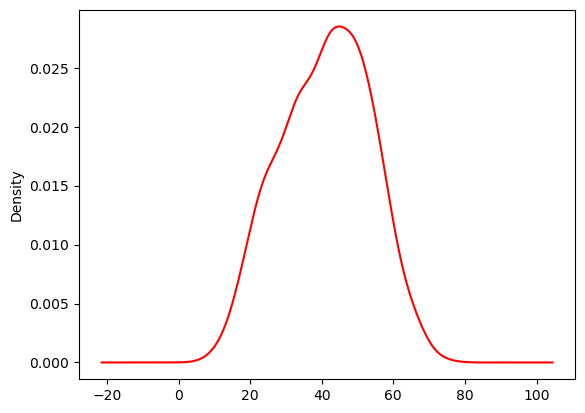

In [15]:
data_scaled['NEXT_W'].plot(kind='kde',c='red')

In [16]:
data_scaled.to_csv('data/nba_data_scaled.csv')

# Training

## Feature/Label Split

In [17]:
def split_data_X_y(data):
    temp = data.copy(deep=False)
    temp.drop(columns=['TEAM_ID','NEXT_SEASON'], inplace=True)
    X = data.iloc[:,2:].copy(deep=False)
    X.drop(columns=['NEXT_W'], inplace=True)
    y = data.iloc[:,-1:].copy(deep=False)
    return X, y

## Train/Val Split

In [18]:
def split_data_train_test(data):
    temp = data.copy(deep=False)
    temp.drop(columns=['TEAM_ID','NEXT_SEASON'], inplace=True)
    X = data.iloc[:,2:].copy(deep=False)
    X.drop(columns=['NEXT_W'], inplace=True)
    y = data.iloc[:,-1:].copy(deep=False)
    X = X.values[:,:,np.newaxis]
    y = y.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023)
    return X_train, X_test, y_train, y_test

In [19]:
def rmse(y_test, y_pred):
    return mean_squared_error(y_test, y_pred, squared=False)

In [20]:
# X, y = split_data_X_y(data_scaled)
# X = X.values[:,:,np.newaxis]

In [21]:
X_train, X_test, y_train, y_test = split_data_train_test(data_scaled)

In [22]:
print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

(312, 19, 1) (135, 19, 1) (312, 1) (135, 1)


# CNN Model

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# 模型训练 早停机制
from tensorflow.keras.callbacks import EarlyStopping

# 定义模型架构
# model = tf.keras.Sequential()
# model.add(layers.Conv1D(128, kernel_size=6, activation='relu', input_shape=(19, 1)))
# #model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(19, 1)))
# model.add(layers.MaxPooling1D(pool_size=3))
# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(1))

# 定义模型架构
model = tf.keras.Sequential()
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(19, 1)))
model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

# monitor:监视参数，min_delta:小于此数认为不变化，mode:loss小好，patience:n周期无提升则退出，restore_best_weights:取最优权重
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='min', verbose=1, restore_best_weights = True)

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 训练模型
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[earlyStop])

Epoch 1/200
8/8 [==============================] - 2s 48ms/step - loss: 1767.5919 - val_loss: 1670.3362
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 1532.8635 - val_loss: 1301.2384
Epoch 3/200
8/8 [==============================] - 0s 15ms/step - loss: 1094.1708 - val_loss: 690.1588
Epoch 4/200
8/8 [==============================] - 0s 16ms/step - loss: 482.8684 - val_loss: 311.9153
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 328.6068 - val_loss: 430.4383
Epoch 6/200
8/8 [==============================] - 0s 15ms/step - loss: 309.2810 - val_loss: 227.4117
Epoch 7/200
8/8 [==============================] - 0s 11ms/step - loss: 252.1514 - val_loss: 219.5943
Epoch 8/200
8/8 [==============================] - 0s 14ms/step - loss: 247.9725 - val_loss: 188.5934
Epoch 9/200
8/8 [==============================] - 0s 14ms/step - loss: 219.2733 - val_loss: 181.6409
Epoch 10/200
8/8 [==============================] - 0s 12ms/step - loss: 205.

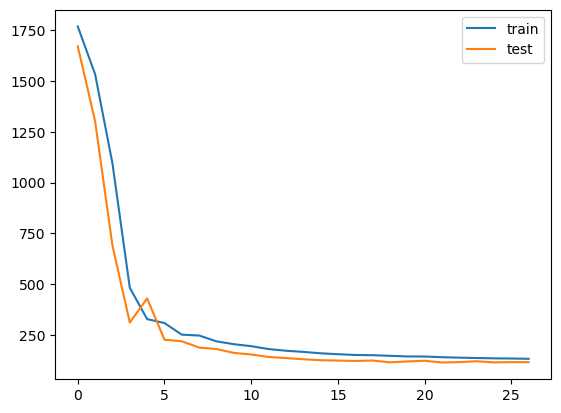

In [24]:
from matplotlib import pyplot as plt
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

def evaluate(y, pred, model = 'model',mode='test'):
    mse = mean_squared_error(y, pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y, pred)
    print(f'{model}: \tMSE\t{mode}:{mse:.4f}\n{model}: \tRMSE\t{mode}:{rmse:.4f}\n{model}: \tMAE\t{mode}:{mae:.4f}\n')

In [26]:
# 进行预测
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 2ms/step


In [27]:
evaluate(y_test,y_pred,'Model test')

Model test: 	MSE	test:134.9590
Model test: 	RMSE	test:11.6172
Model test: 	MAE	test:9.4708



In [28]:
def plot_diff(real,pred,name='name'):
    
    diff = pd.DataFrame(zip(real,pred),columns=['real','pred'])
    ax = diff.plot(marker='$o$',figsize=(15,8),fontsize=12)

    ax.set_xlabel(f"\n{name}",fontsize=15)
    ax.set_ylabel(f"\n Value",fontsize=15)
    # ax.set_yticks(np.arange(0,1.1,0.2))
    # ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])  # 自定义轴坐标label
    ax.set_title(f'{name} Real VS. Predict',fontsize=18)
    ax.legend(fontsize=12) #设置图例字体大小
    plt.legend()
    plt.legend(loc=2) #第二象项，也就是左上角。 loc可以为1,2,3,4
    plt.show();

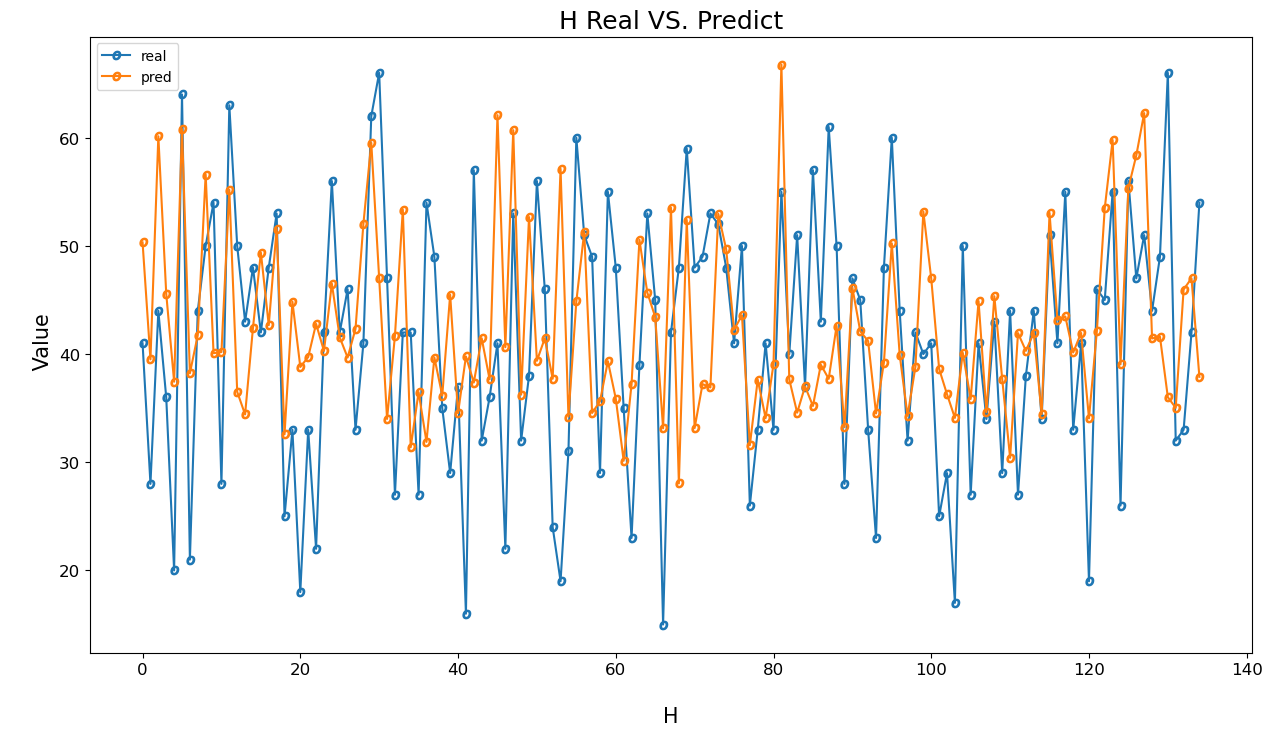

In [29]:
plot_diff(y_test[:,0],y_pred[:,0],name='H')

In [30]:
pd.DataFrame(zip(y_test[:,0],y_pred[:,0]),columns=['real','pred'])

,real,pred
0,41,50.323597
1,28,39.508598
2,44,60.137287
3,36,45.589195
4,20,37.448029
...,...,...
130,66,36.015739
131,32,35.028309
132,33,45.967754
133,42,47.012207


# VQR model

In [31]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler

C:\Users\tojoy\AppData\Local\Temp\ipykernel_39268\1724914734.py:4: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B


In [32]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [35]:
#X_train, X_test, y_train, y_test

In [36]:
num_features = X_train.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)

In [37]:
# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(num_features, name="vf")
ansatz.ry(param_y, 0)

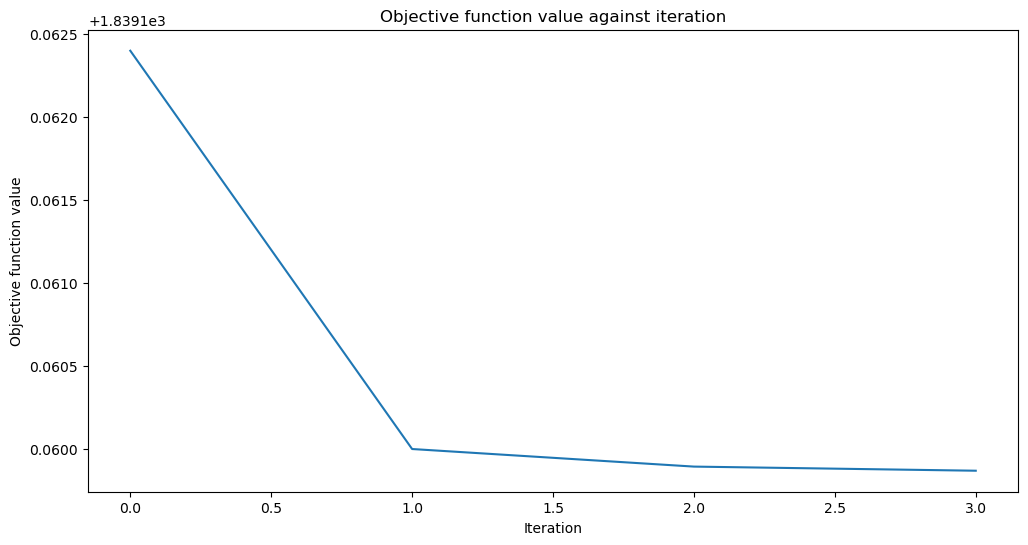

In [38]:
%%time
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=100),
    callback=callback_graph,
    loss="squared_error"
)
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X_train[:,:,0], y_train)
# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

In [40]:
vqr_y_pred = vqr.predict(X_test[:,:,0])

In [41]:
vqr_y_pred

array([[ 6.28514270e-10],
       [ 3.86523158e-07],
       [ 1.20894016e-07],
       [ 8.76720687e-06],
       [ 6.92654087e-05],
       [ 8.18640595e-06],
       [ 2.43780549e-07],
       [-9.12377403e-06],
       [ 7.89807801e-06],
       [-7.28028344e-06],
       [-1.74970870e-06],
       [ 5.41281497e-05],
       [-2.59455817e-06],
       [ 6.93124167e-08],
       [ 2.57419463e-05],
       [-1.25799391e-08],
       [-6.59374222e-07],
       [ 4.53327702e-08],
       [ 2.34922202e-06],
       [ 8.88455383e-07],
       [-3.38167233e-04],
       [ 4.59191914e-08],
       [ 1.40977808e-05],
       [ 1.11352646e-04],
       [ 8.73008529e-05],
       [ 5.07438541e-07],
       [ 2.68463088e-09],
       [ 8.66661752e-04],
       [-1.18888253e-05],
       [-2.71958093e-08],
       [ 3.77252510e-05],
       [ 3.83983798e-08],
       [-1.87244466e-04],
       [ 3.19263190e-07],
       [-1.80171538e-04],
       [ 1.25182441e-07],
       [-4.49427737e-05],
       [-1.58384119e-05],
       [ 3.9

In [42]:
y_pred

array([[50.323597],
       [39.5086  ],
       [60.137287],
       [45.589195],
       [37.44803 ],
       [60.814766],
       [38.230423],
       [41.75228 ],
       [56.597984],
       [40.083176],
       [40.18845 ],
       [55.180313],
       [36.50859 ],
       [34.421227],
       [42.437473],
       [49.38914 ],
       [42.674698],
       [51.607033],
       [32.58097 ],
       [44.847263],
       [38.810013],
       [39.72512 ],
       [42.797432],
       [40.291313],
       [46.51609 ],
       [41.5453  ],
       [39.68212 ],
       [42.330673],
       [52.040512],
       [59.52948 ],
       [47.01705 ],
       [34.004257],
       [41.701096],
       [53.35942 ],
       [31.386612],
       [36.488815],
       [31.88342 ],
       [39.682503],
       [36.167534],
       [45.488297],
       [34.535965],
       [39.77897 ],
       [37.372772],
       [41.465286],
       [37.66867 ],
       [62.088024],
       [40.638157],
       [60.70106 ],
       [36.24963 ],
       [52.672226],
